# Binary Search Tests 

These are some of the tests that we did to verify that the decision boundary generated was, in fact, correctly generated. We did a similar test for the SVM classifier in the documentation notebook where we showed the red line which is the decision boundary generated by the function optimal_point(). 

Here we use logistic regression and show that the points chosen by the optimal_point() function have probabilities for each class around 50% which would show that these are, in fact, decision boundary points.

In [23]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random 
from scipy.interpolate import RBFInterpolator
from scipy.spatial import KDTree
import numba 
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
random.seed(0)
warnings.filterwarnings('ignore', category=UserWarning)

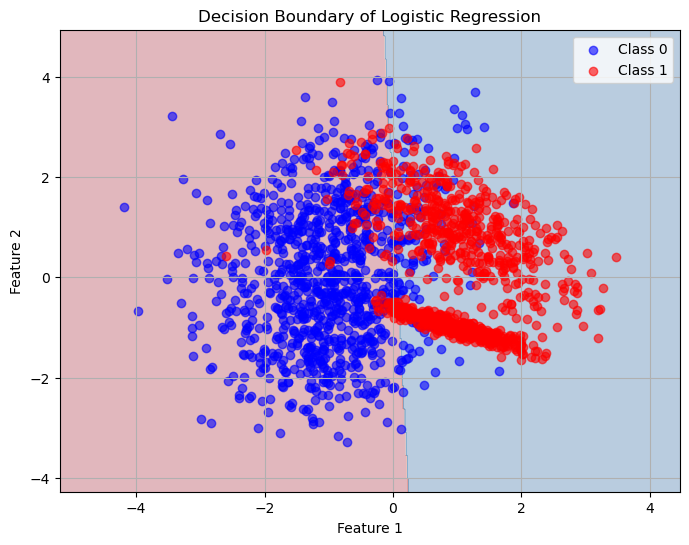

In [24]:
# Reading in the dataset
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=42)
def visualize_dataset():
    clf = LogisticRegression().fit(X, y)
    # Step 2: Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                        np.linspace(y_min, y_max, 500))

    # Step 3: Predict on the grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Step 4: Plot
    plt.figure(figsize=(8, 6))

    # Decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

    # Data points
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0', alpha=0.6)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1', alpha=0.6)

    # Labels and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary of Logistic Regression')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_dataset()

In [3]:
clf = LogisticRegression()

In [4]:
def visualize_dataset():
    plt.figure(figsize=(8, 6))

    plt.scatter(X[y == 0].iloc[:, 0], X[y == 0].iloc[:, 1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X[y == 1].iloc[:, 0], X[y == 1].iloc[:, 1], color='red', label='Class 1', alpha=0.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Binary Classification Data (2 Features)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
def closest_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    if not isinstance(closest_index, np.int64): 
        closest_index = closest_index[0]
    closest_point = contour[closest_index]
    return closest_point

def closest_border_point(border_points, contour): 
    # Build a KDTree for fast nearest neighbor search
    tree = KDTree(contour) 

    min_point, total_min = None, float('inf')

    for border_point in border_points: 
        # Find the distance and index of the closest contour point using KDTree
        dist, _ = tree.query(border_point)

        # Update the minimum point and distance if a closer point is found
        if dist < total_min: 
            total_min = dist 
            min_point = border_point 
    
    return min_point

def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

In [26]:
def move_from_A_to_B_with_x1_displacement(A, B, deltas, epsilon=1e-3):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.
    
    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension
    
    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)
    
    # Calculate direction vector from A to B
    D = B - A
    
    # Calculate the scaling factor t for the desired movement in x1
    t = deltas / (D + epsilon)   # D[0] is the x1 component of the direction vector
    
    # Calculate the new point P based on t
    P = A + t * D

    print(t) 
    print(D)
    
    return P

# Example usage
A = [1, 2, 3]  # Starting point in 3D space
B = [4, 5, 6]  # Target point in 3D space
delta_x1 = 1.5  # Desired movement in x1 dimension

P = move_from_A_to_B_with_x1_displacement(A, B, delta_x1)
print("New point P with desired x1 movement:", P)

[0.49983339 0.49983339 0.49983339]
[3 3 3]
New point P with desired x1 movement: [2.49950017 3.49950017 4.49950017]


In [27]:
def alpha_binary_search(model, point, opp_point, point_target, opp_target, epsilon=0.01):
    """
    Perform a binary search along the line segment between two points to find the
    approximate alpha value where the model's prediction changes from one target
    label to another. This is useful for approximating decision boundaries in
    binary classification by finding the transition point along a segment connecting
    points from opposite classes.

    Parameters
    ----------
    model : object
        A trained machine learning model with a `predict` method that takes a list
        or array of input points and returns predictions as an array. The model
        should be a binary classifier (e.g., from scikit-learn, PyTorch, etc.).
        Example: sklearn.linear_model.LogisticRegression instance.
    
    point : numpy.ndarray
        A 1D array representing the starting point (feature vector) in the feature
        space, typically from one class. Must have the same shape as `opp_point`.
    
    opp_point : numpy.ndarray
        A 1D array representing the opposing point (feature vector) in the feature
        space, typically from the opposite class. Must have the same shape as `point`.
    
    point_target : int or str
        The expected prediction label for the `point`. This is used to initialize
        the search and compare against the model's prediction at interpolated points.
        Should match the model's output format (e.g., 0 or 1 for binary classes).
    
    opp_target : int or str
        The expected prediction label for the `opp_point`. This should be different
        from `point_target` and is used to detect when the prediction flips.
    
    epsilon : float, optional
        The tolerance for convergence in the binary search. The loop stops when the
        difference between the search bounds is less than this value. Default is 0.01.
        Smaller values yield more precise alphas but may increase computation time.

    Returns
    -------
    float
        The approximate alpha value (between 0 and 1) where the model's prediction
        transitions. A value closer to 0 means the boundary is nearer to `point`,
        while closer to 1 means nearer to `opp_point`.

    Raises
    ------
    None explicitly, but may raise exceptions from `model.predict` if the input
    shapes are incompatible or if the model is not properly trained.

    Notes
    -----
    - This function assumes the decision boundary is crossed exactly once along the
      line segment; multiple crossings (e.g., in non-linear models) may lead to
      approximate or incorrect results.
    - The binary search updates bounds based on prediction matches, but if no flip
      occurs (e.g., both points predicted the same), it will converge to a midpoint
      without a true boundary.
    - Usage: Typically called within a loop over pairs of points from different
      classes to sample multiple boundary points.

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.linear_model import LogisticRegression
    >>> model = LogisticRegression().fit(np.array([[0], [1]]), [0, 1])
    >>> point = np.array([0.0])
    >>> opp_point = np.array([1.0])
    >>> alpha = alpha_binary_search(model, point, opp_point, 0, 1, epsilon=0.001)
    >>> print(alpha)  # Approximately 0.5 for a linear boundary at 0.5
    0.5
    """
    start, end = 0, 1  # Initialize search bounds: 0 at 'point', 1 at 'opp_point'
    while abs(end - start) >= epsilon:  # Loop until convergence within epsilon
        alpha = (start + end) / 2  # Midpoint alpha (float division ensured)
        # Interpolate: weighted average between point and opp_point
        temp_candidate = (1 - alpha) * point + alpha * opp_point
        # Predict on the interpolated point (assumes model.predict returns array)
        temp_target = model.predict([temp_candidate])[0]
        if temp_target == point_target: 
            start = alpha  # Move start bound if prediction matches point's target
            point_target = temp_target  # Update target (though often redundant)
        elif temp_target == opp_target: 
            end = alpha  # Move end bound if prediction matches opp's target
            opp_target = temp_target  # Update target (though often redundant)
    return (start + end) / 2  # Return midpoint as approximate transition alpha


def find_decision_boundary(model, X, y, epsilon=1e-3, threshold=10000):
    """
    Approximate the decision boundary of a binary classification model by sampling
    points along line segments between correctly classified points from opposite
    classes. Uses binary search to find transition points and collects them into
    a DataFrame. Handles categorical features by rounding them to integers.

    Parameters
    ----------
    model : object
        A trained binary classification model with a `predict` method that takes
        a list or array of input points and returns predictions as an array.
        Example: sklearn.svm.SVC instance.
    
    X : pandas.DataFrame
        The feature dataset, where rows are samples and columns are features.
        Supports mixed types, including integer categoricals.
    
    y : pandas.Series or numpy.ndarray
        The target labels corresponding to X. Must contain exactly two unique
        binary labels (e.g., 0 and 1).
    
    epsilon : float, optional
        The precision for the binary search in `alpha_binary_search`. Smaller
        values increase accuracy but computation time. Default is 1e-3.
    
    threshold : int, optional
        The maximum number of boundary points to generate. Stops early if reached
        to prevent excessive computation on large datasets. Default is 10000.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the approximated boundary points, with the same
        columns as X. Categorical columns (detected as int types) are converted
        to integers.

    Raises
    ------
    ValueError
        If y does not contain exactly two unique labels (non-binary classification).

    Notes
    -----
    - This function clusters points by true labels (y), then filters pairs where
      the model correctly predicts them (to ensure opposite sides of the boundary).
    - It may miss boundaries if the model has high error rates (few correct pairs).
    - Computational complexity is O(n*m) where n and m are cluster sizes, capped
      by threshold. For large datasets, reduce threshold or sample clusters.
    - A `bool_vec` is created but unused; it may be a remnant for future masking
      (e.g., to ignore categoricals in interpolation).
    - Categorical features are auto-detected as int columns and rounded to int
      in the output for interpretability.
    - Usage: Call after training a model to visualize or analyze its boundary,
      e.g., plot the points in 2D or use for explanations.

    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> from sklearn.svm import SVC
    >>> X = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0]})
    >>> y = np.array([0, 1, 0])
    >>> model = SVC(kernel='linear').fit(X, y)
    >>> boundary = find_decision_boundary(model, X, y, epsilon=0.001, threshold=5)
    >>> print(boundary.shape)  # e.g., (number_of_points, 2)
    (2, 2)
    """
    # Detect categorical features (assumed as int columns)
    categorical_features = X.select_dtypes(include=int).columns.tolist()
    cat_indices = [X.columns.get_loc(col) for col in categorical_features]

    # Create a boolean vector (1 for continuous, 0 for categorical; currently unused)
    bool_vec = [1] * (len(X.columns)) 
    for i in range(len(cat_indices)): 
        bool_vec[cat_indices[i]] = 0 

    X_np = X.to_numpy()  # Convert features to NumPy for efficient ops
    y_np = y.to_numpy() if not isinstance(y, np.ndarray) else y  # Ensure y is NumPy
    boundary_points = []  # List to collect boundary point arrays
    unique_labels = np.unique(y_np)  # Get unique class labels
    if len(unique_labels) != 2:
        raise ValueError("Only supports binary classification.")
    
    label_a, label_b = unique_labels[0], unique_labels[1]  # Assign labels

    # Cluster points by true labels
    cluster_a = X_np[y_np == label_a]
    cluster_b = X_np[y_np == label_b]

    total_N = 0  # Counter for generated points
    for i in range(cluster_a.shape[0]):
        point = cluster_a[i]
        pt_pred = model.predict([point])  # Predict on point from cluster A

        for j in range(cluster_b.shape[0]): 
            match_point = cluster_b[j]
            match_pt_pred = model.predict([match_point])  # Predict on point from B
            # Check if model correctly classifies both (ensures opposite sides)
            if pt_pred.item() == label_a and match_pt_pred.item() == label_b: 
                # Find alpha where prediction flips
                alpha = alpha_binary_search(model, point, match_point, label_a, label_b, epsilon=epsilon)
                # Compute boundary point via interpolation
                boundary = (1 - alpha) * point + alpha * match_point
                boundary_points.append(boundary)

                total_N += 1
                if total_N >= threshold:  # Early stop inner loop
                    break
        if total_N >= threshold:  # Early stop outer loop
            break
    
    # Convert list to DataFrame with original columns
    boundary_pts = pd.DataFrame(data=boundary_points, columns=X.columns)

    # Round categoricals to int for discrete values
    for col in categorical_features: 
        boundary_pts[col] = boundary_pts[col].astype(int)

    return boundary_pts

In [28]:

def get_multi_dim_border_points(center, extents, step=0.1):
    """
    Generate points on the boundaries of an n-dimensional hyperrectangle.
    
    Parameters
    ----------
    center : list or numpy.ndarray
        The center of the hyperrectangle, a list or array of length n (number of dimensions).
    
    extents : list or numpy.ndarray
        The full widths (diameters) in each dimension, a list or array of length n.
        Note: The code uses half-widths internally (extents / 2).
    
    step : float, optional
        Step size for sampling points along each dimension's grid. Smaller values
        increase density but computation time. Default is 0.1.

    Returns
    -------
    list of tuples
        Each tuple represents a point on the boundary of the hyperrectangle.

    Raises
    ------
    None explicitly, but may raise ValueError if center and extents have mismatched lengths,
    or TypeError if inputs are not array-like.

    Notes
    -----
    - Uses a set to avoid duplicate points, which can occur at corners/edges.
    - For each dimension, fixes the boundary (min/max) and grids over others.
    - Handles 1D case specially.
    - Suitable for generating boundary samples in constrained optimization or
      visualization of feasible regions in n-D space.
    - Output as list of tuples for easy conversion to arrays if needed.

    Examples
    --------
    >>> center = [0, 0]
    >>> extents = [2, 2]  # Rectangle from (-1,-1) to (1,1)
    >>> points = get_multi_dim_border_points(center, extents, step=0.5)
    >>> print(len(points))  # e.g., number of sampled boundary points
    16
    """
    center = np.array(center)  # Convert center to NumPy array
    extents = np.array(extents)  # Convert extents to NumPy array
    n = len(center)  # Number of dimensions
    points = set()   # Use set to avoid duplicates
    
    # Define min and max bounds for each dimension (using half-extents)
    bounds = [(c - e / 2, c + e / 2) for c, e in zip(center, extents)]
    
    # For each dimension, generate points on the lower and upper boundaries
    for dim in range(n):
        # For lower and upper boundary in this dimension
        for bound_val in [bounds[dim][0], bounds[dim][1]]:
            # Generate grid points for all other dimensions
            other_dims = [i for i in range(n) if i != dim]
            ranges = [np.arange(bounds[i][0], bounds[i][1] + step, step) for i in other_dims]
            if not ranges:  # Handle 1D case
                points.add(tuple([bound_val] if dim == 0 else []))
                continue
            # Create meshgrid for other dimensions
            grids = np.meshgrid(*ranges, indexing='ij')
            coords = [grid.ravel() for grid in grids]
            
            # Construct points
            for coord in zip(*coords):
                point = [0] * n
                # Set the current dimension to the boundary value
                point[dim] = bound_val
                # Set other dimensions to the grid values
                for i, val in zip(other_dims, coord):
                    point[i] = val
                points.add(tuple(point))  # Add as tuple to set
    
    return list(points)

def det_constraints(datapt, deltas): 
    """
    Determine the effective constraints based on deltas, scaling them relative to the data point.

    Parameters
    ----------
    datapt : list or numpy.ndarray
        The data point (feature vector) to scale constraints against.
    
    deltas : list
        List of delta values for each feature. If float/int, it's treated as a percentage
        (e.g., 10 means 10% of datapt[i]); otherwise ignored.

    Returns
    -------
    tuple
        (constraints: list of scaled delta values or -1 if not applicable,
         len_constr: int count of active constraints)

    Raises
    ------
    None explicitly, but may raise TypeError if datapt/deltas are incompatible.

    Notes
    -----
    - Initializes constraints as [-1] * len(deltas), updating only for numeric deltas.
    - Scaling: constraint[i] = (deltas[i] / 100) * datapt[i], assuming percentages.
    - Used to count and quantify constraints for bounded regions.
    - Usage: Pre-process deltas before applying bounds in optimization or counterfactuals.

    Examples
    --------
    >>> datapt = [100, 200]
    >>> deltas = [10, 'none']  # 10% for first, ignore second
    >>> constraints, len_constr = det_constraints(datapt, deltas)
    >>> print(constraints, len_constr)  # [10.0, -1], 1
    [10.0, -1] 1
    """
    constraints = [-1] * len(deltas)  # Initialize with -1 (inactive)
    len_constr = 0  # Counter for active constraints
    for i in range(len(deltas)): 
        if type(deltas[i]) == float or type(deltas[i]) == int:  # Check if numeric
            constraints[i] = (deltas[i]/100)*datapt[i]  # Scale as percentage of datapt
            len_constr+=1  # Increment counter
    return constraints, len_constr

def constraint_bounds(contours, datapt, constraints): 
    """
    Filter contour points to those within specified bounds based on constraints.

    Parameters
    ----------
    contours : numpy.ndarray
        Array of contour points (shape: (n_points, n_features)).
    
    datapt : numpy.ndarray
        The reference data point (shape: (1, n_features)) to center bounds around.
    
    constraints : list
        List of delta values (bounds widths) for each feature; >0 activates filtering.

    Returns
    -------
    numpy.ndarray
        Filtered contour points within the bounds.

    Raises
    ------
    Exception
        If no constraints are assigned (all <=0).

    Notes
    -----
    - For each active constraint, computes [x - delta/2, x + delta/2] and filters.
    - Sequentially applies filters, potentially reducing points cumulatively.
    - Includes plotting of bounds (vertical/horizontal lines for dims 0/1).
    - Assumes 2D for plotting; extend for higher dims if needed.
    - Usage: Constrain boundary points in optimization, e.g., feasible counterfactuals.

    Examples
    --------
    >>> contours = np.array([[0,0], [1,1], [2,2], [3,3]])
    >>> datapt = np.array([[1,1]])
    >>> constraints = [2, 2]  # Bounds width 2 for each
    >>> bounded = constraint_bounds(contours, datapt, constraints)
    >>> print(bounded)  # e.g., array([[0,0], [1,1], [2,2]])
    """
    if len(constraints) == 0: 
        raise Exception("No constraints were assigned.")
    bounded_contour = contours.copy()  # Copy to avoid modifying original
    for i in range(len(constraints)): 
        if constraints[i] > 0:  # Active if >0
            x = datapt[0][i]  # Reference value for dimension i
            # This should just be the delta
            delta_x = constraints[i]
            # Generate a lower and upper bounds on each constraint
            lowb_x, highb_x = x - (delta_x / 2), x + (delta_x / 2)
            contour_arr = bounded_contour[:, i]  # Extract column i
            # Choose the correct indices for the multi-dimensional df
            indices = np.where((contour_arr >= lowb_x) & (contour_arr <= highb_x))
            bounded_contour_pts = bounded_contour[indices]  # Filter rows
            bounded_contour = bounded_contour_pts  # Update
            if i == 0:  # Plot vertical lines for dim 0
                plt.axvline(x=highb_x, color='b', linestyle='-', label='High Bound x')
                plt.axvline(x=lowb_x, color='b', linestyle='-', label='Low bound x')
            else:   # Plot horizontal for dim 1 (assumes 2D)
                plt.axhline(y=highb_x, color='b', linestyle='-', label='High Bound y')
                plt.axhline(y=lowb_x, color='b', linestyle='-', label='Low bound y')
    return bounded_contour

def real_world_constraints(points, undesired_coords, constraints): 
    """
    Filter points based on real-world constraints relative to undesired_coords.

    Parameters
    ----------
    points : pandas.DataFrame
        DataFrame of points to filter, with feature columns.
    
    undesired_coords : list or array
        The reference ("undesired") point coordinates, matching points' features.
    
    constraints : list of lists, optional
        Each sublist: [feature_name (str), operator ('equal', 'greater', or other for <)].
        Empty list returns points unchanged.

    Returns
    -------
    pandas.DataFrame
        Filtered points satisfying all constraints.

    Raises
    ------
    None explicitly, but may raise KeyError if feature_name not in points.columns,
    or IndexError if constraints malformed.

    Notes
    -----
    - Sequentially applies filters: == for 'equal', > for 'greater', < otherwise.
    - Uses column index from get_loc for comparison value.
    - Useful for imposing domain-specific rules, e.g., in counterfactual explanations.
    - If constraints empty, returns original points.
    - Usage: Post-process boundary points to respect real-world feasibility.

    Examples
    --------
    >>> points = pd.DataFrame({'pt1': [1,2,3], 'pt2': [4,5,6], 'pt3': [10,11,12]}, columns=['feat1','feat2','feat3'])
    >>> undesired_coords = [1,2,5]
    >>> constraints = [['feat1', 'greater']]
    >>> filtered = real_world_constraints(points, undesired_coords, constraints)
    >>> print(filtered)  # pd.DataFrame(data=[[4,5,6], [10,11,12]]) # Since feat1 = 1 for the undesired point, we select all points that have feat1 > 1
    >>> constraints = [['feat1', 'greater'], ['feat2', 'less']]. 
    >>> filtered = real_world_constraints(points, undesired_coords, constraints)
    >>> print(filtered)  # pd.DataFrame(data=[]) # Since feat2 = 2 for the undesired point, we select all points that have feat2 < 2. 
    """
    if len(constraints) == 0: 
        return points 
    
    for constraint in constraints: 
        select_pts = None
        if constraint[1] == "equal":  # Filter equal to undesired value
            select_pts = points.loc[points[constraint[0]] == undesired_coords[points.columns.get_loc(constraint[0])], :]
        elif constraint[1] == "greater":  # Filter greater than
            select_pts = points.loc[points[constraint[0]] > undesired_coords[points.columns.get_loc(constraint[0])], :] 
        else:  # Default: less than
            select_pts = points.loc[points[constraint[0]] < undesired_coords[points.columns.get_loc(constraint[0])], :]

        points = select_pts  # Update with filtered
    
    return points

In [29]:
def optimal_point(dataset, model, desired_class, original_class, undesired_coords, threshold=10000, point_epsilon=0.1, epsilon=0.01, constraints=[], deltas=[]): 
    """
    Finds the closest point to the decision boundary from an undesired point,
    optionally constrained by real-world conditions.
    This essentially finds the counterfactual explanation for a given point by minimizing the distance to the given boundary.
    This method is important because it addresses a key problem with the original optimal_point() function where we generated an R^n dimensional grid that we would then have to iterate over. 
    The problem with iterating over such a grid is eventually that we will hit a memory error for high-dimensional features such as 20, 30 or 40 features. This will cause the function to crash. 
    Additionally, due to the exponential increase of the number of features to search, the grid will become infeasible to search (curse of dimensionality). 

    Parameters
    ----------
    dataset : pd.DataFrame
        Full dataset containing features and a final column with class labels.
    
    model : sklearn-like classifier
        A binary classification model with a `.fit()` and `.predict()` method.
    
    desired_class : int or label
        The target class we want the corrected point to belong to.
    
    original_class : int or label
        The actual class label of the undesired point.
    
    undesired_coords : list or array
        The coordinates of the original ("unhealthy") point.
    
    threshold : int, optional
        Max number of decision boundary points to sample. Default is 10000.
    
    point_epsilon : float, optional
        Precision used to estimate decision boundary points. Default is 0.1.
    
    epsilon : float, optional
        Step size used when displacing a point toward the decision boundary. Default is 0.01.
    
    constraints : list, optional
        A list of real-world constraints on the features (e.g., ranges, logic constraints). Default is [].
    
    deltas : list, optional
        Tolerances or maximum displacements for each feature. Default is [].

    Returns
    -------
    np.ndarray
        A corrected point that satisfies the class change and real-world constraints.

    Raises
    ------
    Exception
        If the number of constraints exceeds the number of features.

    Notes
    -----
    - This function trains the model on the provided dataset, generates boundary points using
      `find_decision_boundary`, applies constraints, and finds the closest optimal point.
    - Assumes binary classification and relies on external functions like `real_world_constraints`,
      `closest_point`, `move_from_A_to_B_with_x1_displacement`, etc., which must be defined elsewhere.
    - Includes plotting for visualization (e.g., boundary contours, points), which requires matplotlib.
    - The function blends boundary approximation with counterfactual generation, useful for explainable AI.
    - Print statements are for progress tracking; plotting is partially commented out but can be enabled.
    - Usage: Call with a dataset and model to generate counterfactuals, e.g., for model interpretation or optimization.

    Examples
    --------
    >>> import pandas as pd
    >>> from sklearn.linear_model import LogisticRegression
    >>> dataset = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0], 'label': [0, 1, 0]})
    >>> model = LogisticRegression()
    >>> undesired_coords = [2, 0]  # Example point from class 0
    >>> optimal = optimal_point(dataset, model, desired_class=1, original_class=0, undesired_coords=undesired_coords)
    >>> print(optimal)  # e.g., array([[1.5, 0.5]])
    """
    # -------------------------------
    # STEP 1: Train the model
    # -------------------------------
    X_train = dataset.iloc[:, 0:-1]  # Extract features from dataset
    y_train = dataset.iloc[:, -1]  # Extract labels from dataset
    n_features = X_train.shape[1]  # Get number of features

    print("fitting model...")
    model.fit(X_train, y_train)  # Train the model on the dataset
    print("model finished.")

    # -------------------------------
    # STEP 2: Find decision boundary
    # -------------------------------
    print("boundary points started generation...")

    # This step uses binary interpolation to get points close to the decision boundary
    boundary_points = find_decision_boundary(model, X_train, y_train,
                                             threshold=threshold, epsilon=point_epsilon)
    print("boundary points finished.")
    print(boundary_points.shape)

    # -------------------------------
    # STEP 3: Apply real-world constraints (optional)
    # -------------------------------
    # Reduce boundary points based on external rules (e.g., cost limits, physics constraints)
    contours = real_world_constraints(points=boundary_points,
                                      undesired_coords=undesired_coords,
                                      constraints=constraints)
    contours = np.unique(contours.to_numpy(), axis=0)  # Remove duplicates from constrained points
    undesired_datapt = np.reshape(np.array(list(undesired_coords)), (1, -1))  # Reshape undesired point to 2D array

    # -------------------------------
    # STEP 4: Find closest point on constrained boundary
    # -------------------------------
    print("Finding the closest point from the contour line to the point...")
    optimal_datapt = closest_point(undesired_datapt, contour=contours)
    print("Finding the closest point from the contour line to the point.")  # Note: Duplicate print, possibly a typo
    plt.plot(contours[:,0], contours[:,1], lw=2.5, color='black')  
    plt.scatter(X_train[y_train == desired_class].iloc[:, 0], X_train[y_train == desired_class].iloc[:, 1], color='blue', alpha=0.5)
    plt.scatter(X_train[y_train == original_class].iloc[:, 0], X_train[y_train == original_class].iloc[:, 1], color='red', alpha=0.5)

    # -------------------------------
    # STEP 5: Post-process based on class flip requirement
    # -------------------------------

    # If we want to *flip* the class of the point...
    if desired_class != original_class: 
         # Move in the direction of the boundary, slightly overshooting
        D = optimal_datapt - undesired_datapt  # Compute direction vector
        deltas = D * (1+epsilon)  # Scale by (1 + epsilon) to overshoot
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    else:
        # If we want to *stay within* the same class (more constrained)
        closest_boundedpt = None
        deltas, len_constr = det_constraints(datapt=undesired_datapt[0], deltas=deltas)  # Determine constraints

        if len_constr > X_train.shape[1]:
            raise Exception("There cannot be more constraints than features")

        elif len_constr == X_train.shape[1]:
            # All n dimensions are constrained, so generate an exact grid of boundary candidates
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0],
                                                              extents=deltas,
                                                              step=0.05)
            np_bounded_contour = np.array(bounded_contour_pts)  # Convert to NumPy array
            x_values, y_values = np_bounded_contour[:, 0], np_bounded_contour[:, 1]  # Extract x/y for plotting
            plt.scatter(x_values, y_values, color='blue', marker='o')  # Plot bounded points
            closest_boundedpt = closest_border_point(bounded_contour_pts, contour=contours)  # Find closest on border

        else:
            # Partially constrained - less than n dimensions are constrained
            bounded_contour_pts = constraint_bounds(contours, undesired_datapt, deltas)  # Apply partial bounds
            closest_boundedpt = closest_point(point=undesired_datapt, contour=bounded_contour_pts)  # Find closest
        
        D = closest_boundedpt - undesired_datapt  # Compute direction
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)  # Move point
    
    # Plot original and optimal points with connecting line
    plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r')  # Plot undesired point
    plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')  # Label 'NH' (e.g., Non-Healthy)
    plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'g')  # Plot optimal point (changed to green for distinction)
    plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'H')  # Label 'H' (e.g., Healthy; adjusted from duplicate 'NH')
    plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')  # Dashed line between points
    return optimal_datapt

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(40000, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07091364 1.09224355]]
[[-1.17214014 -0.04910383]]


array([[-0.06816218,  1.10615382]])

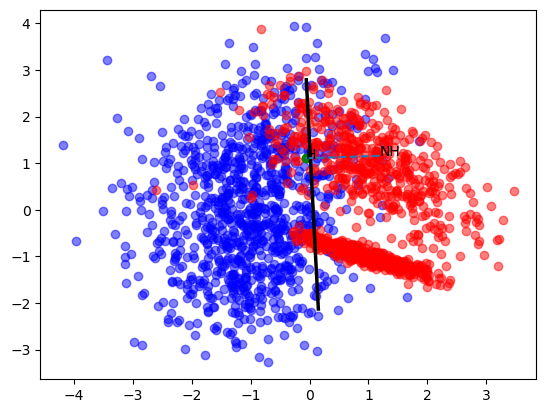

In [18]:
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=42)
y = y.reshape(-1,1)
df1 = pd.DataFrame(data=np.hstack((X,y)))
optimal_point(df1, model=clf, desired_class=0, original_class=1, threshold=40000, undesired_coords=df1.iloc[1,:df1.shape[1]-1], point_epsilon=1e-6, epsilon=0.07)

In [32]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=42)
y = y.reshape(-1,1)
df1 = pd.DataFrame(data=np.hstack((X,y)))
df1.head(n=20)

,0,1,2
0,0.771440,-1.262335,0.0
1,-1.292116,-0.409111,0.0
2,-1.427221,1.619316,1.0
3,-1.862943,1.682255,1.0
4,1.326361,0.320554,0.0
5,-1.034796,1.110975,1.0
6,-1.993211,1.841957,1.0
7,-1.348937,-0.368258,0.0
8,-0.373500,0.298467,1.0
9,0.718320,-0.761266,0.0


fitting model...
model finished.
boundary points started generation...
boundary points finished.
(50000, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07517996 1.07146551]]
[[-0.20756549 -0.73111989]]


array([[-1.25796641,  0.32760554]])

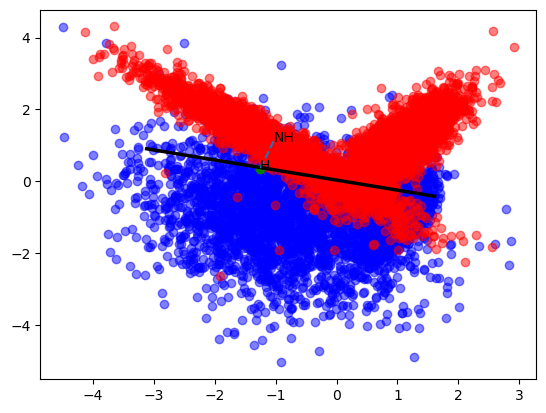

In [33]:
optimal_point(df1, model=clf, desired_class=0, original_class=1, threshold=50000, undesired_coords=df1.iloc[5,:df1.shape[1]-1], point_epsilon=1e-4, epsilon=0.07)

In [34]:
X, y = make_classification(n_samples=5000, n_features=51, n_informative=51, n_redundant=0, random_state=42, n_classes=2)
model = LogisticRegression()
y = y.reshape(-1,1)
df2 = pd.DataFrame(data=np.hstack((X,y)))

In [35]:
df2.head(n=20)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.889818,-0.825471,-0.210590,-2.856535,0.693125,-5.642883,13.209183,2.692199,2.754073,0.154228,...,4.763202,-8.303519,7.321253,3.601108,-0.558062,-1.212654,-1.164403,5.169363,2.574095,0.0
1,-0.533984,0.648952,5.596394,-1.086707,3.761104,-0.575370,0.717226,-0.937345,3.652855,-1.342487,...,-9.360450,4.785849,-1.701105,7.119621,2.658547,8.195286,-3.946856,3.000733,4.328823,0.0
2,2.033743,9.216104,0.312689,8.534617,3.320922,12.268958,4.130554,0.337084,-1.688427,4.053550,...,-0.178872,-3.389753,-1.872875,-1.069837,-0.570060,-4.019157,2.106338,-0.453622,8.896160,1.0
3,3.548917,-2.776485,-0.502533,-1.643888,-3.347425,-1.213385,-1.763432,4.233040,3.097054,1.838008,...,-5.090086,-2.142888,0.463514,5.350892,9.514657,1.502027,-6.088132,-1.611844,4.862071,0.0
4,1.836552,1.321849,1.110293,-1.874105,8.346437,-3.875414,6.787884,-8.278707,-4.424594,-1.511528,...,-2.231427,-2.255901,-3.239298,-6.304000,-0.982316,-0.314802,-0.314574,1.746531,-1.043861,0.0
5,-0.627999,-5.528049,7.192905,-9.926754,-2.221568,-2.418471,2.623397,-3.642304,9.030754,-10.775797,...,0.821346,-1.316148,-6.303034,-2.263331,-2.055183,-4.059419,8.829769,5.441648,-2.108828,0.0
6,5.248394,-2.663301,-1.746750,-5.692389,2.791261,8.984965,0.216811,-2.887568,3.045782,1.286896,...,2.215828,4.928237,-6.905289,-1.556822,6.876809,2.770610,-1.368626,2.599783,3.268692,1.0
7,1.314891,-3.624251,-0.361765,0.346872,-6.676465,-2.117156,4.612547,-6.950891,-1.690517,-2.652964,...,-1.707671,13.285689,-3.387991,7.707082,-3.304093,-2.604836,-3.185184,-8.098049,5.171999,0.0
8,-2.734525,3.440586,0.533125,-3.387532,-1.106004,5.480290,1.794000,-7.370089,-6.214151,-3.343983,...,1.969268,2.412086,0.799031,5.125025,-5.037852,-10.174208,4.286708,-8.222617,4.057116,0.0
9,2.385793,-4.917558,4.217357,-1.185870,-1.121265,-2.119290,2.136316,2.974162,-5.493993,5.880466,...,5.879503,-3.585599,-6.478724,0.132547,-4.884468,-4.336502,2.260819,-1.775854,-1.839208,0.0


In [37]:
X, y = make_classification(n_samples=2000, n_features=15, n_informative=15, n_redundant=0, random_state=42, n_classes=2)
model = LogisticRegression()
y = y.reshape(-1,1)
model.fit(X,y)
df = pd.DataFrame(data=np.hstack((X,y)))
X_train, y_train = df.iloc[:, 0:df.shape[1]-1], df.iloc[:, -1]
boundary_points = find_decision_boundary(model, X_train, y_train, threshold=100000, epsilon=0.001)

# Print the decision bo un dary points
print("Decision Boundary Points (All Features):")  
print(boundary_points)
print(boundary_points.shape)

Decision Boundary Points (All Features):
             0         1         2         3         4         5         6   \
0      2.369585 -1.351390  0.094711  2.852573 -0.324875 -0.017309 -2.752407   
1      1.473153  0.757774  1.012075  0.488519 -0.564815 -0.097017 -0.915814   
2     -0.282054 -1.570078  0.879929 -2.103625 -0.144037  3.411897 -0.900515   
3      1.102887 -0.495668  0.733615 -1.184181  0.874849  0.747012 -2.384590   
4     -0.598473  0.205176  1.352843 -0.580474  0.816945  1.267767 -2.331672   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.355467 -1.805574 -1.295771  0.856053 -0.546467 -3.399595 -2.749625   
99996 -0.066653 -3.521888 -0.089580  1.908437 -1.543887 -0.834238  1.544267   
99997 -2.096058  1.729946 -0.901767 -0.975980 -0.499336 -0.914900  0.376535   
99998 -0.114115 -3.423584 -0.381095 -0.711484 -0.564491 -1.978658 -0.181640   
99999  0.513989 -3.251636  0.249425 -0.875341  2.001836 -1.929756 -1.101490   

          

In [38]:
preds = model.predict_proba(boundary_points)
print(np.mean(preds, axis=0))

[0.49999935 0.50000065]


In [39]:
X, y = make_classification(n_samples=2000, n_features=50, n_informative=50, n_redundant=0, random_state=42, n_classes=2)
model = LogisticRegression()
y = y.reshape(-1,1)
model.fit(X,y)
df = pd.DataFrame(data=np.hstack((X,y)))
X_train, y_train = df.iloc[:, 0:df.shape[1]-1], df.iloc[:, -1]
boundary_points = find_decision_boundary(model, X_train, y_train, threshold=100000, epsilon=0.001)

# Print the decision bo un dary points
print("Decision Boundary Points (All Features):")  
print(boundary_points)
print(boundary_points.shape)

Decision Boundary Points (All Features):
             0         1         2         3         4         5         6   \
0      1.973519  3.225116  0.881461 -2.437803  0.733066  0.374925  1.669612   
1      5.906268  3.354182 -2.340616 -0.391458  3.382398 -3.113276  2.728039   
2      1.769622 -7.396224  4.649305  3.521387 -0.675656  0.690153  5.299348   
3      0.405650 -2.386030  0.832463  1.360850  4.483055 -3.337000  0.082923   
4      3.108239  0.048599  0.656815 -2.660741 -1.335320 -2.876994  3.534857   
...         ...       ...       ...       ...       ...       ...       ...   
99995  2.396400  5.030826 -9.979294  2.860295  2.081675 -4.388009  3.244053   
99996  4.452583  3.984398 -2.831981  3.064961 -0.697742  3.940255  2.518502   
99997  5.395358  3.193585 -4.898301 -3.230795 -2.827506 -1.417269  5.543933   
99998  3.194718  2.790848 -6.699281  1.432563  0.099357  3.585391  1.153527   
99999 -4.339952 -4.545742  1.713882  0.620163  3.357615 -7.294594 -1.995686   

          

In [40]:
preds = model.predict_proba(boundary_points)
print(np.mean(preds, axis=0))

[0.50000048 0.49999952]
